# Drake Davis Final Project Analysis Notebook

In [19]:
# Loading in packages/important setup

import pandas as pd, numpy as np, scipy.stats as st, statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.linear_model import RidgeCV, LassoCV, LinearRegression
from sklearn.metrics import r2_score
import statsmodels.formula.api as smf
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression          
from sklearn.neighbors import KNeighborsClassifier            
from sklearn.metrics import accuracy_score, roc_auc_score     
import matplotlib.pyplot as plt     
import seaborn as sns                
from sklearn.ensemble import RandomForestClassifier   

FILE = "movies_boxoffice_2017_2020_merged.csv"
df   = pd.read_csv(FILE, parse_dates=["calendar_date", "release_date"])


In [20]:
df["per_theater"] = df["daily_gross"] / df["theaters"]
df["quarter"]     = df["calendar_date"].dt.quarter

### Q1: Elasticity vs. theaters 

In [21]:
# How much does screen count drive opening‑day revenue?


q1 = df[df["daily_gross"] > 0].copy()
X1 = np.log(q1[["theaters"]])
y1 = np.log(q1["daily_gross"])

regr1 = LinearRegression().fit(X1, y1)
print(f"\nQ1Elasticity  (theaters) = {regr1.coef_[0]:.3f}, "
      f"R squared = {r2_score(y1, regr1.predict(X1)):.3f},  n = {len(q1)}")

sns.regplot(x=np.log(q1["theaters"]), y=np.log(q1["daily_gross"]),
            scatter_kws={"alpha":.4}, line_kws={"color":"red"})
plt.xlabel("log(Theaters)"); plt.ylabel("log(Opening Gross)")
plt.title("Opening Day Gross vs. Theaters (log‑log)")
plt.tight_layout(); plt.savefig("plot_q1_theaters.png", dpi=300); plt.clf()


Q1Elasticity  (theaters) = 1.016, R squared = 0.644,  n = 303


<Figure size 640x480 with 0 Axes>

#### Q2: Elasticity of opening day gross with respect to budget

In [22]:
q2 = (df.dropna(subset=["budget","daily_gross"])
        .query("budget>0 and daily_gross>0").copy())
X2 = np.log(q2[["budget"]])
y2 = np.log(q2["daily_gross"])

regr2 = LinearRegression().fit(X2, y2)
print(f"Q2 Elasticity (budget)   = {regr2.coef_[0]:.3f}, "
      f"R Squared = {r2_score(y2, regr2.predict(X2)):.3f},  n = {len(q2)}")

Q2 Elasticity (budget)   = 0.814, R Squared = 0.475,  n = 30


In [23]:
# More machine learning

f = pd.read_csv("movies_boxoffice_2017_2020_merged.csv",
                 parse_dates=["calendar_date","release_date"])

df["log_budget"]  = np.log(df["budget"])
df["log_open"]    = np.log(df["daily_gross"])
df["log_theater"] = np.log(df["theaters"])
df["quarter"]     = df["calendar_date"].dt.quarter

df_q2 = (df.dropna(subset=["budget","daily_gross"])
           .query("budget > 0 and daily_gross > 0")
           .copy())

# Feature matrix & target 
X = df_q2[["log_budget", "log_theater", "quarter"]]
y = df_q2["log_open"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)

# Define models
models = {
    "Linear": LinearRegression(),
    "Ridge":  RidgeCV(alphas=np.logspace(-3,3,13)),
    "Lasso":  LassoCV(alphas=np.logspace(-3,3,13), max_iter=5000),
    "RF":     RandomForestRegressor(n_estimators=200, random_state=42)
}

results = []
for name, mdl in models.items():
    pipe = make_pipeline(StandardScaler(with_mean=False), mdl)
    pipe.fit(X_train, y_train)
    preds = pipe.predict(X_test)
    rmse = mean_squared_error(y_test, preds, squared=False)
    r2   = r2_score(y_test, preds)
    results.append({"Model":name, "RMSE":rmse, "R²":r2})

perf = (pd.DataFrame(results)
          .sort_values("R²", ascending=False)
          .reset_index(drop=True))
print(perf)

    Model      RMSE        R²
0  Linear  0.834098  0.453949
1      RF  0.866764  0.410342
2   Ridge  0.951152  0.289934
3   Lasso  1.063478  0.112321


c:\Users\drake\anaconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


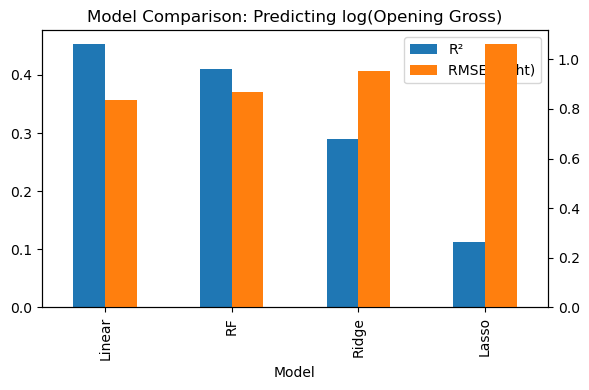

In [24]:
# Plot 

perf.set_index("Model")[["R²","RMSE"]].plot(kind="bar", secondary_y="RMSE",
                                            figsize=(6,4), legend=True)
plt.title("Model Comparison: Predicting log(Opening Gross)")
plt.tight_layout(); plt.savefig("plot_ml_comparison.png", dpi=300)
plt.show()

### Q3: Does per‑theater efficiency vary by calendar quarter?

In [25]:
anova = smf.ols("per_theater ~ C(quarter)", data=df).fit(cov_type="HC3")
print("\nQ3 Welch-ANOVA on per-theater by quarter")
print(anova.summary().tables[1])

sns.boxplot(x="quarter", y="per_theater", data=df)
plt.title("Q3: Per-Theater Gross by Quarter (2017-2020)")
plt.tight_layout(); plt.savefig("plot_q3_boxplot.png", dpi=300); plt.clf()


Q3 Welch-ANOVA on per-theater by quarter
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept        1366.8336    200.701      6.810      0.000     973.467    1760.200
C(quarter)[T.2]   435.8882    401.307      1.086      0.277    -350.660    1222.436
C(quarter)[T.3]   244.7537    436.664      0.561      0.575    -611.093    1100.600
C(quarter)[T.4]   612.6896    555.468      1.103      0.270    -476.008    1701.387


<Figure size 640x480 with 0 Axes>

### Q4: Which major studio is most efficient per theater?


In [26]:
def canonical_major(studio):
    s = str(studio).lower()
    if "warner"    in s: return "Warner Bros."
    if "universal" in s: return "Universal"
    if "paramount" in s: return "Paramount"
    if "sony" in s or "columbia" in s: return "Sony"
    if "disney" in s or "buena vista" in s: return "Disney"
    return None               

df["major"] = df["studio"].apply(canonical_major)

stats = (df.dropna(subset=["major", "per_theater"])
           .groupby("major")["per_theater"]
           .agg(["mean","count","std"])
           .assign(se=lambda d: d["std"]/np.sqrt(d["count"]),
                   ci_low=lambda d: d["mean"]-1.96*d["se"],
                   ci_hi =lambda d: d["mean"]+1.96*d["se"])
           .sort_values("mean", ascending=False))

print("\nQ4 Studio per-theater averages (95 % CI, alias-corrected)")
print(stats[["mean","count","ci_low","ci_hi"]])


Q4 Studio per-theater averages (95 % CI, alias-corrected)
                     mean  count       ci_low        ci_hi
major                                                     
Disney        2706.711943     41  1759.075326  3654.348559
Sony          1767.503733     81   699.745915  2835.261551
Warner Bros.  1597.587126     71   923.818849  2271.355403
Universal     1390.937505     64   673.574732  2108.300279
Paramount     1253.017057     46   536.895738  1969.138375


### Q5 · Can we classify a movie as an opening‑day **“hit”** vs **“flop”?  
We treat “hit” = opening‑day (log) gross ≥ the 75ᵗʰ percentile of the sample,  
and train three lecture‑covered classifiers (Logistic Regression, K‑NN, Random Forest).  
Accuracy and ROC AUC are reported on a 25 % hold‑out test set.



Q5 Hit vs Flop classification (test set)
     Model  Accuracy   ROC_AUC
0     KNN     0.875  0.916667
1  LogReg     0.750  0.833333
2      RF     0.875  0.666667


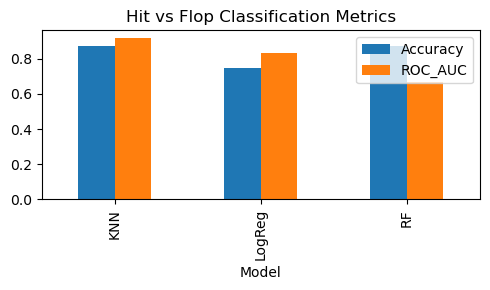

In [27]:

# 1) Label: 1 = top‑quartile opening‑day gross, 0 otherwise
q75 = df_q2["log_open"].quantile(0.75)
df_q2["hit"] = (df_q2["log_open"] >= q75).astype(int)

# 2) Features and target
X_cls = df_q2[["log_budget", "log_theater", "quarter"]]
y_cls = df_q2["hit"]

X_train, X_test, y_train, y_test = train_test_split(
    X_cls, y_cls, test_size=0.25, random_state=42, stratify=y_cls
)


models_cls = {
    "LogReg": LogisticRegression(max_iter=2000),
    "KNN":    KNeighborsClassifier(n_neighbors=7),
    "RF":     RandomForestClassifier(n_estimators=300, random_state=42)
}

results_cls = []
for name, mdl in models_cls.items():
    pipe = make_pipeline(StandardScaler(with_mean=False), mdl)
    pipe.fit(X_train, y_train)
    preds  = pipe.predict(X_test)
    proba  = pipe.predict_proba(X_test)[:, 1] if hasattr(pipe, "predict_proba") else preds
    
    acc   = accuracy_score(y_test, preds)
    auc   = roc_auc_score(y_test, proba)
    results_cls.append({"Model": name, "Accuracy": acc, "ROC_AUC": auc})

cls_tbl = (pd.DataFrame(results_cls)
             .sort_values("ROC_AUC", ascending=False)
             .reset_index(drop=True))

print("\nQ5 Hit vs Flop classification (test set)\n", cls_tbl)

# 4) Plot: accuracy & ROC AUC
cls_tbl.set_index("Model")[["Accuracy", "ROC_AUC"]].plot(kind="bar", figsize=(5,3))
plt.title("Hit vs Flop Classification Metrics")
plt.tight_layout(); plt.savefig("plot_q5_classifiers.png", dpi=300); plt.show()
